# A3: NeuralNetwork Class

Name: Ivan Morrow

## Requirements

In this assignment, you will complete the implementation of the `NeuralNetwork` class, based on your solution to `A2` and [08a Optimizers](https://www.cs.colostate.edu/~anderson/cs545/notebooks/08a%20Optimizers.ipynb), using the code included in the next code cell.  Your implementation must meet the requirements described in the doc-strings.

Run the code in [08a Optimizers](https://www.cs.colostate.edu/~anderson/cs545/notebooks/08%20Optimizers.ipynb) to create the file `optimizers.py` for use in this assignment.

Then apply your `NeuralNetwork` class to the problem of predicting the rental of bicycles in Seoul as described below.

## Code for `NeuralNetwork` Class Saved in File `neuralnetworkA3.py`

In [145]:
%%writefile neuralnetworkA3.py

import numpy as np
import optimizers as opt


class NeuralNetwork():
    """
    A class that represents a neural network for nonlinear regression.

    Attributes
    ----------
    n_inputs : int
        The number of values in each sample
    n_hiddens_each_layer : list of ints, or empty
        The number of units in each hidden layer.
        Its length specifies the number of hidden layers.
    n_outputs : int
        The number of units in output layer
    all_weights : one-dimensional numpy array
        Contains all weights of the network as a vector
    Ws : list of two-dimensional numpy arrays
        Contains matrices of weights in each layer,
        as views into all_weights
    all_gradients : one-dimensional numpy array
        Contains all gradients of mean square error with
        respect to each weight in the network as a vector
    Grads : list of two-dimensional numpy arrays
        Contains matrices of gradients weights in each layer,
        as views into all_gradients
    error_trace : list of floats
        Mean square error (unstandardized) after each epoch
    n_epochs : int
        Number of epochs trained so far
    X_means : one-dimensional numpy array
        Means of the components, or features, across samples
    X_stds : one-dimensional numpy array
        Standard deviations of the components, or features, across samples
    T_means : one-dimensional numpy array
        Means of the components of the targets, across samples
    T_stds : one-dimensional numpy array
        Standard deviations of the components of the targets, across samples
        
        
    Methods
    -------
    _make_weights_and_views(shapes)
        Creates all initial weights and views for each layer

    train(Xtrain, Ttrain, Xvalidate, Tvalidate, n_epochs, batch_size=-1, method='sgd', 
          learning_rate=None, momentum=0, weight_penalty=0, verbose=True)
        Trains the network using input and target samples by rows in Xtrain and Ttrain

    use(X)
        Applies network to inputs X and returns network's output
    """

    def __init__(self, n_inputs, n_hiddens_each_layer, n_outputs):
        """Creates a neural network with the given structure

        Parameters
        ----------
        n_inputs : int
            The number of values in each sample
        n_hiddens_each_layer : list of ints, or empty
            The number of units in each hidden layer.
            Its length specifies the number of hidden layers.
        n_outputs : int
            The number of units in output layer

        Returns
        -------
        NeuralNetwork object
        """

        self.n_inputs = n_inputs
        self.n_hiddens_each_layer = n_hiddens_each_layer
        self.n_outputs = n_outputs

        # Create list of shapes of weight matrices for each layer
        shapes = []
        shapes = self._set_shapes(shapes)
        self.shapes = shapes
        
        # Build one-dimensional vector of all weights and weight matrices
        # for each layer as views into this vector.
        # Call _make_weights_and_views to create all_weights and Ws       
        self.all_weights, self.Ws = self._make_weights_and_views(shapes)

        # Call _make_weights_and_views to create all_gradients and Grads        
        self.all_gradients, self.Grads = self._make_weights_and_views(shapes, isGrad=True)

        
        self.X_means = None
        self.X_stds = None
        self.T_means = None
        self.T_stds = None

        self.n_epochs = 0
        self.error_trace = []

    def _make_weights_and_views(self, shapes, isGrad=False, verbose=False):
        """Creates vector of all weights and views for each layer

        Parameters
        ----------
        shapes : list of pairs of ints
            Each pair is number of rows and columns of weights in each layer.
            Number of rows is number of inputs to layer (including constant 1).
            Number of columns is number of units, or outputs, in layer.

        Returns
        -------
        Vector of all weights, and list of views into this vector for each layer
        """
        if isGrad and verbose:
            print(f'Initializing gradients...')
            
        # Create one-dimensional numpy array of all weights with random initial values between -1 and 1.
        total_weights = sum(weight_shape[0]*weight_shape[1] for weight_shape in shapes)

        # use random nums b/t -1 and 1 if weights, else zeros
        all_weights = np.random.uniform(-1, 1, size=total_weights) if not isGrad else np.zeros(shape=total_weights)

        if verbose:
            print(f'Weights: {all_weights}')
            print(f'Weight Shapes: {shapes}')

        # Build weight matrices as list of views (pairs of number of rows and number 
        # of columns) by reshaping corresponding elements from vector of all weights 
        # into correct shape for each layer and dividing values of each weight matrix 
        # by the square root of number of its inputs. Remember to use /=
        prev_index = 0
        Ws = []
        for shape in shapes:
            weights_in_layer = shape[0]*shape[1]
            layer_weight_matrix = np.reshape(all_weights[prev_index:prev_index+weights_in_layer], shape)
            # if we are dealing with weights, divide by sqrt of num inputs, else do nothing
            if not isGrad:
                layer_weight_matrix /= np.sqrt(shape[0])
            
            Ws.append(layer_weight_matrix)
            prev_index += weights_in_layer

        # Set output layer weights to zero.
        Ws[-1][:] = 0
        
        return all_weights, Ws
        
    def _set_shapes(self, W_shapes = []):
        """
        Args:
            self: NeuralNetwork class
            W_shapes (list): empty list by default, will hold shapes of weights in each layer

        Iterates over each layer of NN and fetches the number of units in each given layer from self.n_hiddens_each_layer.
        If looking at the very first layer, use the model inputs as the units_prev_layer variable. Otherwise,
        fetch the units in the previous hidden layer from n_hiddens_each_layer using the index.

        Stores shapes of layer as tuple of inputs to layer and outputs of layer.

        Returns
        -------
        List of pairs of ints
            Each pair is number of rows and columns of weights in each layer.
            Number of rows is number of inputs to layer (including constant 1).
            Number of columns is number of units, or outputs, in layer.
        """
        num_layers = len(self.n_hiddens_each_layer)
        
        if num_layers >= 1:
            for layer in range(num_layers):
                units_in_layer = self.n_hiddens_each_layer[layer]
                if layer == 0:
                    units_prev_layer = self.n_inputs
                else:
                    units_prev_layer = self.n_hiddens_each_layer[layer - 1]
                # add 1 to units_prev_layer for constant 1s, second is number of outputs in this layer
                W_shapes.append((1 + units_prev_layer, units_in_layer))
            
            # shape for output layer
            W_shapes.append((1 + self.n_hiddens_each_layer[-1], self.n_outputs))
        else:
            W_shapes.append((1 + self.n_inputs, self.n_outputs))

        return W_shapes

    def print_shapes(self):
        print(f'Weight shapes: {self.shapes}')
        
    def __repr__(self):
        return f'NeuralNetwork({self.n_inputs}, {self.n_hiddens_each_layer}, {self.n_outputs})'
     
    def __str__(self):
        if self.n_epochs is not None:
            return f'{self.__repr__()} trained for {self.n_epochs} epochs with a final RMSE of {self.rmse}.'   
        else:
            return f'{self.__repr__()} has not been trained.'
 
 
    def train(self, Xtrain, Ttrain, Xvalidate, Tvalidate, n_epochs, batch_size=-1,
              method='sgd', learning_rate=None, momentum=0, weight_penalty=0, verbose=True):
        """Updates the weights.

        Parameters
        ----------
        Xtrain : two-dimensional numpy array 
            number of training samples  by  number of input components
        Ttrain : two-dimensional numpy array
            number of training samples  by  number of output components
        Xvalidate : two-dimensional numpy array 
            number of validation samples  by  number of input components
        Tvalidate : two-dimensional numpy array
            number of validationg samples  by  number of output components
        n_epochs : int
            Number of passes to take through all samples
        batch_size : int
            if -1, then whole training set used as one batch
        method : str
            'sgd', 'adam', or 'scg'
        learning_rate : float
            Controls the step size of each update, only for sgd and adam
        momentum : float
            Controls amount of previous weight update to add to current weight update, only for sgd
        weight_penalty : float
            Controls amount to penalize large magnitude weights
        verbose: boolean
            If True, progress is shown with print statements
        """

        # if batch_size == -1 use all input data as batch
        self.batch_size = batch_size if batch_size != -1 else self.n_inputs

        if self.X_means is None:
            # Calculate and assign standardization parameters
            self.X_means = Xtrain.mean(axis=0)
            self.X_stds = Xtrain.std(axis=0)
            self.T_means = Ttrain.mean(axis=0)
            self.T_stds = Ttrain.std(axis=0)

        # Standardize Xtrain, Ttrain, Xvalidate and Tvalidate.
        XtrainS = (Xtrain - self.X_means) / self.X_stds
        TtrainS = (Ttrain - self.T_means) / self.T_stds

        XvalS = (Xtrain - self.X_means) / self.X_stds
        TvalS = (Ttrain - self.T_means) / self.T_stds

        # Instantiate Optimizers object by giving it vector of all weights
        optimizer = opt.Optimizers(self.all_weights)

        # Define function to convert mean-square error to root-mean-square error,
        # Here we use a lambda function just to illustrate its use.  
        # We could have also defined this function with
        # def error_convert_f(err):
        #     return np.sqrt(err)

        error_convert_f = lambda err: np.sqrt(err)
        
        # Call the requested optimizer method to train the weights.

        if method == 'sgd':
            self.error_trace = optimizer.sgd(Xtrain, Ttrain, Xvalidate, Tvalidate,
                                             self.error_f, self.gradient_f, 
                                             n_epochs=n_epochs,
                                             batch_size=batch_size,
                                             learning_rate=learning_rate,
                                             momentum=momentum, weight_penalty=weight_penalty,
                                             verbose=verbose)


        elif method == 'adamw':
            self.error_trace = optimizer.adamw(Xtrain, Ttrain, Xvalidate, Tvalidate,
                                               self.error_f, self.gradient_f,
                                               n_epochs=n_epochs,
                                               batch_size=batch_size,
                                               learning_rate=learning_rate,
                                               weight_penalty=weight_penalty,
                                               verbose=verbose)

        elif method == 'scg':
            self.error_trace = optimizer.scg(Xtrain, Ttrain, Xvalidate, Tvalidate,
                                             self.error_f, self.gradient_f,
                                             n_epochs=n_epochs,
                                             batch_size=batch_size,
                                             weight_penalty=weight_penalty,
                                             verbose=verbose)

        else:
            raise Exception("method must be 'sgd', 'adam', or 'scg'")

        self.n_epochs += len(self.error_trace)
        self.best_epoch = optimizer.best_epoch

        # Return neural network object to allow applying other methods
        # after training, such as:    Y = nnet.train(X, T, 100, 0.01).use(X)

        return self

    def _add_ones(self, X):
        return np.insert(X, 0, 1, 1)
        
    def _forward(self, X):
        """Calculate outputs of each layer given inputs in X.
        
        Parameters
        ----------
        X : input samples, standardized.

        Returns
        -------
        Standardized outputs of all layers as list, include X as first element.
        """
        self.Zs = [X]
        input = X
        # Append output of each layer to list in self.Zs, then return it.
        for i, weights in enumerate(self.Ws):
            # add ones to input matrix for mat mul with weights & biases
            input = self._add_ones(input)
            # apply tanh activation function on all hidden layers
            if i < len(self.Ws) - 1:
                layer_output = np.tanh(input @ weights)
            # no activation function on output layer
            else:
                layer_output = input @ weights
            self.Zs.append(layer_output)
            input = layer_output

        return self.Zs

    # Function to be minimized by optimizer method, mean squared error
    def error_f(self, X, T):
        """Calculate output of net given input X and its mean squared error.
        Function to be minimized by optimizer.

        Parameters
        ----------
        X : two-dimensional numpy array, standardized
            number of samples  by  number of input components
        T : two-dimensional numpy array, standardized
            number of samples  by  number of output components

        Returns
        -------
        Standardized mean square error as scalar float that is the mean
        square error over all samples and all network outputs.
        """
        # Call _forward, calculate mean square error and return it.
        outputs = self._forward(X)
        mse = np.mean((T - outputs[-1])**2)
        
        return mse

    # Gradient of function to be minimized for use by optimizer method
    def gradient_f(self, X, T):
        """Returns gradient wrt all weights. Assumes _forward already called
        so input and all layer outputs stored in self.Zs

        Parameters
        ----------
        X : two-dimensional numpy array, standardized
            number of samples  x  number of input components
        T : two-dimensional numpy array, standardized
            number of samples  x  number of output components

        Returns
        -------
        Vector of gradients of mean square error wrt all weights
        """

        # Assumes forward_pass just called with layer outputs saved in self.Zs.
        
        n_samples = X.shape[0]
        n_outputs = T.shape[1]
        n_layers = len(self.n_hiddens_each_layer) + 1

        # delta is delta matrix to be back propagated.
        # Dividing by n_samples and n_outputs here replaces the scaling of
        # the learning rate.
        delta = -(T - self.Zs[-1]) / (n_samples * n_outputs)
        
        # Step backwards through the layers to back-propagate the error (delta)        
        for layeri in range(n_layers - 1, -1, -1):
            # Add bias term
            current_layer_input_with_bias = self._add_ones(self.Zs[layeri])
            self.Grads[layeri][:] = current_layer_input_with_bias.T @ delta
            
           # Back-propagate this layer's delta to previous layer
            if layeri > 0:
                delta = delta @ self.Ws[layeri][1:, :].T # * (1 - self.Zs[layeri-1]**2)
                delta *= (1 - self.Zs[layeri] ** 2)

        return self.all_gradients

    def use(self, X):
        """Return the output of the network for input samples as rows in X.
        X assumed to not be standardized.

        Parameters
        ----------
        X : two-dimensional numpy array
            number of samples  by  number of input components, unstandardized

        Returns
        -------
        Output of neural network, unstandardized, as numpy array
        of shape  number of samples  by  number of outputs
        """

        # Standardize X
        Xmeans = X.mean(axis=0)
        Xstds = X.std(axis=0)
        Xs = (X - Xmeans) / Xstds
        
        # Call _forward to get the neural network's output
        outputs = self._forward(X)[-1]
        
        # Unstandardize output Y before returning it
        Y = (outputs*Xstds) + Xmeans
        
        return Y

    def get_error_trace(self):
        """Returns list of root-mean square error for each epoch"""
        return self.error_trace

Overwriting neuralnetworkA3.py


## Example Results

Here we test the `NeuralNetwork` class with some simple data.  


In [148]:
%load_ext autoreload
%autoreload 2

import numpy as np
import matplotlib.pyplot as plt

import neuralnetworkA3 as nn  # Your file produced from the above code cell.

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [149]:
X = np.arange(0, 2, 0.5).reshape(-1, 1)
T = np.sin(X) * np.sin(X * 10)
X.shape, T.shape

((4, 1), (4, 1))

In [150]:
nnet = nn.NeuralNetwork(X.shape[1], [2, 2], 1)
    
# Set all weights here to allow comparison of your calculations
# Must use [:] to overwrite values in all_weights.
# Without [:], new array is assigned to self.all_weights, so self.Ws no longer refer to same memory
nnet.all_weights[:] = np.arange(len(nnet.all_weights)) * 0.001
nnet.train(X, T, X, T, n_epochs=1, batch_size=-1, method='sgd', learning_rate=0.1)

nnet.Ws

SGD: Epoch 1 MSE=0.21074,0.21074


[array([[-1.15975619e-06,  9.98484558e-04],
        [ 2.00095631e-03,  3.00124951e-03]]),
 array([[0.00391495, 0.00490722],
        [0.00600014, 0.00700015],
        [0.00800013, 0.00900014]]),
 array([[0.00226822],
        [0.01096924],
        [0.01196153]])]

In [151]:
nnet.all_gradients, nnet.Grads

(array([ 1.15975619e-05,  1.51544172e-05, -9.56310066e-06, -1.24951242e-05,
         8.50482759e-04,  9.27791094e-04, -1.40261939e-06, -1.53011581e-06,
        -1.25340105e-06, -1.36733322e-06,  7.73178378e-02,  3.07593071e-04,
         3.84667898e-04]),
 [array([[ 1.15975619e-05,  1.51544172e-05],
         [-9.56310066e-06, -1.24951242e-05]]),
  array([[ 8.50482759e-04,  9.27791094e-04],
         [-1.40261939e-06, -1.53011581e-06],
         [-1.25340105e-06, -1.36733322e-06]]),
  array([[0.07731784],
         [0.00030759],
         [0.00038467]])])

In [152]:
nnet.Zs

[array([[0. ],
        [0.5],
        [1. ],
        [1.5]]),
 array([[-1.15975619e-06,  9.98484226e-04],
        [ 9.99318066e-04,  2.49910411e-03],
        [ 1.99979389e-03,  3.99971274e-03],
        [ 3.00026571e-03,  5.50030336e-03]]),
 array([[0.00392291, 0.00491616],
        [0.00394092, 0.00493667],
        [0.00395893, 0.00495718],
        [0.00397694, 0.00497769]]),
 array([[0.00237005],
        [0.0023705 ],
        [0.00237094],
        [0.00237138]])]

In [153]:
nnet.Grads

[array([[ 1.15975619e-05,  1.51544172e-05],
        [-9.56310066e-06, -1.24951242e-05]]),
 array([[ 8.50482759e-04,  9.27791094e-04],
        [-1.40261939e-06, -1.53011581e-06],
        [-1.25340105e-06, -1.36733322e-06]]),
 array([[0.07731784],
        [0.00030759],
        [0.00038467]])]

In [154]:
Y = nnet.use(X)
Y

array([[0.7513249 ],
       [0.75132515],
       [0.75132539],
       [0.75132564]])

## More Detailed Example Use

In [156]:
Xtrain = np.arange(-2, 2, 0.05).reshape(-1, 1)
Ttrain = np.sin(Xtrain) * np.sin(Xtrain * 5)
    
Xval = Xtrain * 1.1  
Tval = Ttrain + 0.2 * Xtrain
Xtest = Xtrain * 0.97
Ttest = Ttrain + 0.15 * Xtrain # + np.random.uniform(-0.05, 0.05, Ttrain.shape) 

In [157]:
errors = []
Ytests = []
n_epochs = 4000
method_rhos = [('sgd', 0.05),
               ('adamw', 0.005),
               ('scg', None)] 

SGD: Epoch 400 MSE=0.21242,0.26425
SGD: Epoch 800 MSE=0.16241,0.23740
SGD: Epoch 1200 MSE=0.12797,0.24412
SGD: Epoch 1600 MSE=0.11670,0.28034
SGD: Epoch 2000 MSE=0.10166,0.28310
SGD: Epoch 2400 MSE=0.06063,0.26729
SGD: Epoch 2800 MSE=0.00749,0.19337
SGD: Epoch 3200 MSE=0.00133,0.19762
SGD: Epoch 3600 MSE=0.00094,0.20200
SGD: Epoch 4000 MSE=0.00077,0.20473
AdamW: Epoch 400 MSE=0.00517,0.17918
AdamW: Epoch 800 MSE=0.00357,0.19165
AdamW: Epoch 1200 MSE=0.00022,0.19077
AdamW: Epoch 1600 MSE=0.00008,0.19000
AdamW: Epoch 2000 MSE=0.00007,0.19230
AdamW: Epoch 2400 MSE=0.00003,0.19335
AdamW: Epoch 2800 MSE=0.00003,0.19439
AdamW: Epoch 3200 MSE=0.00005,0.19564
AdamW: Epoch 3600 MSE=0.00004,0.19629
AdamW: Epoch 4000 MSE=0.00001,0.19678
SCG: Epoch 0 MSE=0.27298,0.32936
SCG: Epoch 400 MSE=0.00074,0.20406
SCG: Epoch 800 MSE=0.00014,0.22620
SCG: Epoch 1200 MSE=0.00005,0.21925
SCG: Epoch 1600 MSE=0.00003,0.21341
SCG: Epoch 2000 MSE=0.00002,0.21167
SCG: Epoch 2400 MSE=0.00001,0.20892
SCG: Epoch 2800 M

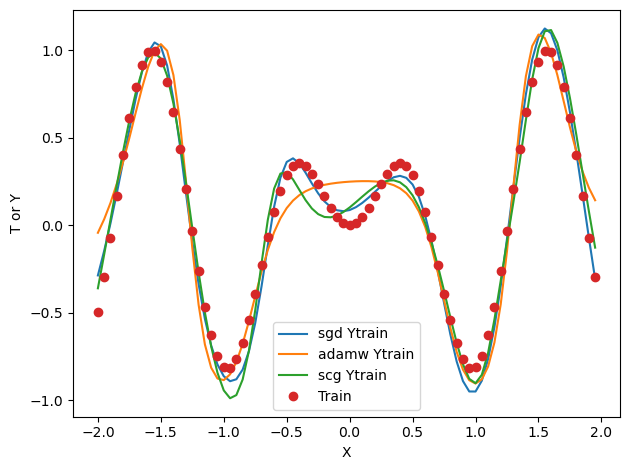

In [158]:
for method, rho in method_rhos:
    nnet = nn.NeuralNetwork(Xtrain.shape[1], [10, 10], 1)
    nnet.train(Xtrain, Ttrain, Xval, Tval, n_epochs, batch_size=-1, method=method, learning_rate=rho,
               momentum=0.9)  # momentum only affects sgd)
    Ytrain = nnet.use(Xtrain)
    plt.plot(Xtrain, Ytrain, '-', label=method + ' Ytrain')
    errors.append(nnet.get_error_trace())
    Ytests.append(nnet.use(Xtest))

plt.plot(Xtrain, Ttrain, 'o', label='Train')
plt.xlabel('X')
plt.ylabel('T or Y')
plt.legend()
plt.tight_layout()

In [159]:
errors = np.stack(errors)
# errors is now 3 x n_epochs x 2
errors.shape

(3, 4000, 2)

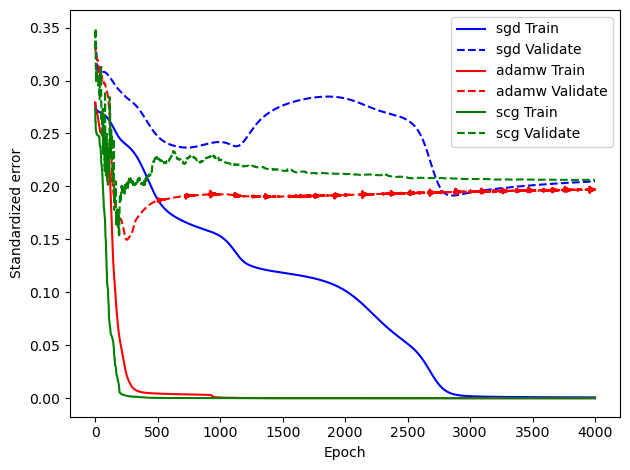

In [160]:
colors = ['b', 'r', 'g']
styles = ['-', '--']
for methodi, method in enumerate([mr[0] for mr in method_rhos]):
    for train_val_i, train_val in enumerate(['Train', 'Validate']):
        plt.plot(errors[methodi, :, train_val_i], f'{colors[methodi]}{styles[train_val_i]}',
                 label=f'{method} {train_val}')
plt.xlabel('Epoch')
plt.ylabel('Standardized error')
plt.legend()
plt.tight_layout()

In [161]:
def plot_Y_vs_T(Y, T, title):
    plt.plot(T, Y, 'o', alpha=0.6)
    a = min(min(T), min(Y))[0]
    b = max(max(T), max(Y))[0]
    plt.axline((a, a), (b, b), linewidth=4, color='r', alpha=0.5)
    plt.xlabel('T')
    plt.ylabel('Y')
    plt.title(title)

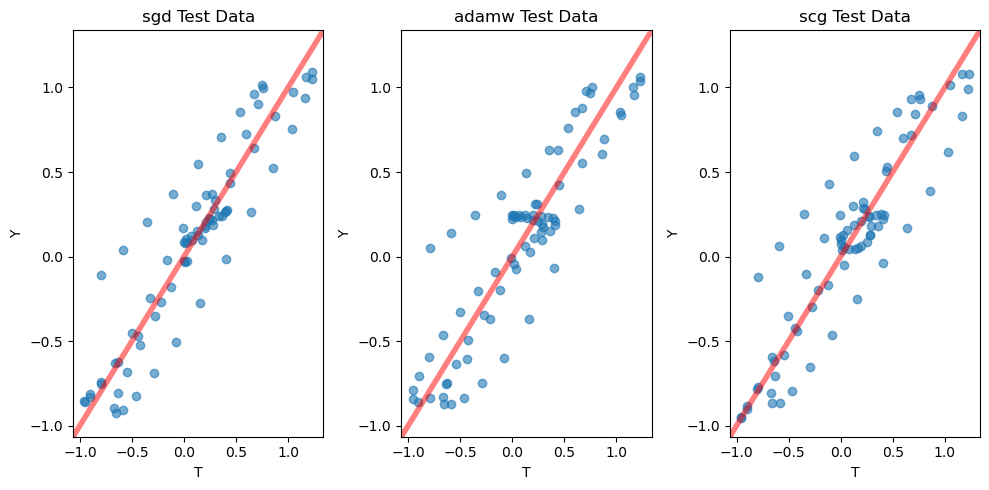

In [162]:
plt.figure(figsize=(10, 5))
for i in range(3):
    plt.subplot(1, 3, i+1)
    plot_Y_vs_T(Ytests[i], Ttest, f'{method_rhos[i][0]} Test Data')
plt.tight_layout()

# Application

Use your neural network implementation to create a model for predicting the [critical temperature](https://www.energy.gov/science/doe-explainssuperconductivity) of superconductive materials based on attributes of the materials.  Download and extract the data from [this UCI ML Repository site](https://archive.ics.uci.edu/dataset/464/superconductivty+data).  This site explains the data and has a link to an introductory paper.  The data consists of 81 attributes extracted from 21,263 superconductors in the first 81 columns and the critical temperature for each in the 82nd column.  So, the first 81 columns will form your input $X$ matrix and the last column will be your target $T$ matrix.

## Task

Your task is to do the following. Partition the data into partitions of 60%, 20% and 20% for the training, validation and test sets, respectively. Try training with each of the three optimization methods and reasonable values for the other parameters. Plot the `error_trace`s for example runs of each of three methods.  <font color=red>Discuss what you see in the plots.</font>

In [187]:
import pandas as pd

data = pd.read_csv('train.csv')
data.columns

Index(['number_of_elements', 'mean_atomic_mass', 'wtd_mean_atomic_mass',
       'gmean_atomic_mass', 'wtd_gmean_atomic_mass', 'entropy_atomic_mass',
       'wtd_entropy_atomic_mass', 'range_atomic_mass', 'wtd_range_atomic_mass',
       'std_atomic_mass', 'wtd_std_atomic_mass', 'mean_fie', 'wtd_mean_fie',
       'gmean_fie', 'wtd_gmean_fie', 'entropy_fie', 'wtd_entropy_fie',
       'range_fie', 'wtd_range_fie', 'std_fie', 'wtd_std_fie',
       'mean_atomic_radius', 'wtd_mean_atomic_radius', 'gmean_atomic_radius',
       'wtd_gmean_atomic_radius', 'entropy_atomic_radius',
       'wtd_entropy_atomic_radius', 'range_atomic_radius',
       'wtd_range_atomic_radius', 'std_atomic_radius', 'wtd_std_atomic_radius',
       'mean_Density', 'wtd_mean_Density', 'gmean_Density',
       'wtd_gmean_Density', 'entropy_Density', 'wtd_entropy_Density',
       'range_Density', 'wtd_range_Density', 'std_Density', 'wtd_std_Density',
       'mean_ElectronAffinity', 'wtd_mean_ElectronAffinity',
       'gmean_

In [189]:
data_np = data.to_numpy()
X = data_np[:, :-1]
T = data_np[:, -1:] 
X.shape, T.shape

((21263, 81), (21263, 1))

In [191]:
num_examples = X.shape[0]
round(num_examples * 0.6)

12758

In [193]:
train_perc = 0.6
val_perc = 0.2
test_perc = 0.2

num_examples = X.shape[0]
# shuffle X
# Generate a permutation of indices
permutation = np.random.permutation(len(X))

# Apply this permutation to both arrays
X_shuffled = X[permutation]
T_shuffled = T[permutation]

# first 60% rows to train
train_split = round(num_examples * 0.6)
Xtrain = X_shuffled[0:train_split]
Ttrain = T_shuffled[0:train_split]

# next 20% to val
val_split = round(num_examples * 0.2)
Xval = X_shuffled[train_split:train_split+val_split]
Tval = T_shuffled[train_split:train_split+val_split]

# last 20% to test
Xtest = X_shuffled[train_split+val_split:]
Ttest = T_shuffled[train_split+val_split:]

In [195]:
Xtrain.shape,  Ttrain.shape, Xval.shape, Tval.shape, Xtest.shape, Ttest.shape

((12758, 81), (12758, 1), (4253, 81), (4253, 1), (4252, 81), (4252, 1))

In [50]:
net = nn.NeuralNetwork(Xtrain.shape[1], [40, 20, 10], 1)
net.print_shapes()

Weight shapes: [(82, 40), (41, 20), (21, 10), (11, 1)]


In [51]:
errors = []
Ytests = []
n_epochs = 100
method_rhos = [('sgd', 0.05),
               ('adamw', 0.005),
               ('scg', None)]

for method, rho in method_rhos:
    nnet = nn.NeuralNetwork(Xtrain.shape[1], [40, 20, 10], 1)
    nnet.train(Xtrain, Ttrain, Xval, Tval, n_epochs, batch_size=-1, method=method, learning_rate=rho,
               momentum=0.9)  # momentum only affects sgd)
    Ytrain = nnet.use(Xtrain)
    # plt.plot(Xtrain, Ytrain, '-', label=method + ' Ytrain')
    errors.append(nnet.get_error_trace())
    Ytests.append(nnet.use(Xtest))

SGD: Epoch 10 MSE=1368.01099,1341.49843
SGD: Epoch 20 MSE=1212.07894,1200.98985
SGD: Epoch 30 MSE=1207.20131,1195.74193
SGD: Epoch 40 MSE=1182.77149,1165.88600
SGD: Epoch 50 MSE=1183.97799,1166.81605
SGD: Epoch 60 MSE=1180.43357,1165.14128
SGD: Epoch 70 MSE=1180.75875,1165.70032
SGD: Epoch 80 MSE=1180.27398,1164.58073
SGD: Epoch 90 MSE=1180.32889,1164.50723
SGD: Epoch 100 MSE=1180.26568,1164.65599
AdamW: Epoch 10 MSE=2352.34933,2305.44843
AdamW: Epoch 20 MSE=2309.00798,2262.47665
AdamW: Epoch 30 MSE=2267.22157,2221.42299
AdamW: Epoch 40 MSE=2227.46357,2182.32052
AdamW: Epoch 50 MSE=2189.37669,2144.86289
AdamW: Epoch 60 MSE=2152.82935,2108.92088
AdamW: Epoch 70 MSE=2117.68335,2074.35721
AdamW: Epoch 80 MSE=2083.80992,2041.04632
AdamW: Epoch 90 MSE=2051.10342,2008.88589
AdamW: Epoch 100 MSE=2019.48081,1977.79558
SCG: Epoch 0 MSE=1050.40950,1035.99874
SCG: Epoch 10 MSE=977.50128,964.32177
SCG: Epoch 20 MSE=955.31148,941.35331
SCG: Epoch 30 MSE=912.95370,899.97837
SCG: Epoch 40 MSE=863.462

In [53]:
errors = np.stack(errors)
# errors is now 3 x n_epochs x 2
errors.shape

(3, 100, 2)

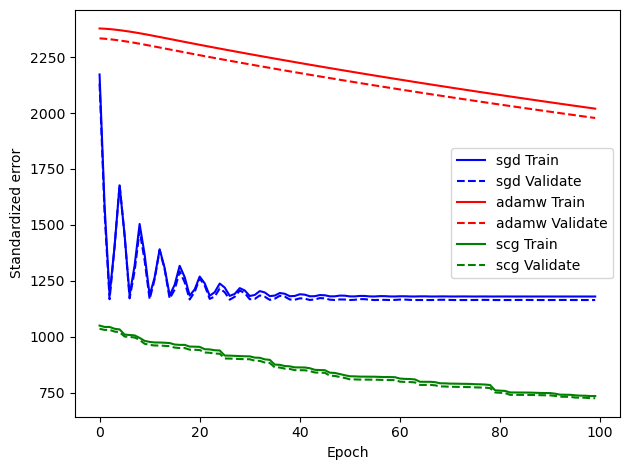

In [55]:
colors = ['b', 'r', 'g']
styles = ['-', '--']

for methodi, method in enumerate([mr[0] for mr in method_rhos]):
    for train_val_i, train_val in enumerate(['Train', 'Validate']):
        plt.plot(errors[methodi, :, train_val_i], f'{colors[methodi]}{styles[train_val_i]}',
                 label=f'{method} {train_val}')
plt.xlabel('Epoch')
plt.ylabel('Standardized error')
plt.legend()
plt.tight_layout()

### Analysis

Looking at the plot of the errors over 100 epochs, the first thing that stands out to me is that the errors on this data
are much larger than the error we saw on the example data a few cells above. I am not sure if this is a problem with my implementation or
if it's just reflective of the dataset.

Looking at the individual optimizer errors, adamw an almost linear descent with epochs. It looks like if epochs were increased, then adamw error would continue to go down. The validation data does the same thing. The slope is not quite linear, but it's close.

Looking at sgd next, it looks like in the early epochs it had alternating very large errors followed by much lower errors. This is likely due to it bouncing back and forth around a local minima. You can see as the epochs go on, the fluctuation in slowed significantly. After bouncing around, around epoch 40 the error rate just flat lined until the training finished. This seems like it reach the local minima and didn't see anywhere else to go.

Lastly, scg performed the best out of the three optimizers. SCD's error progressively decreased and showed no signs of stopping after 100 epochs. It's not completely linear, there are some very small steps but it did achieve the lowest error overall. In fact, the very first error it recorded is lower than any of the errors from the other two optimizers. SCG out performed the othe two optimizers by a lot on this training run. It appears it could have gone down further given more epochs.

## Task

Write code using nested for loops to iterate over all three optimization methods, several hidden layer structures, several numbers of epochs, several learning rates, and several batch sizes.  In a list of lists, collect the method, number of epochs, learning rate, batch size, and RMSEs for training, validation, and test data. After all for loops have completed, convert the resulting list of lists into a `pandas.DataFrame` with appropriate column names. Sort it by ascending test set RMSEs and print the `DataFrame`.  It may be helpful to also do this for each iteration of the outer-most for loop.  You should set `verbose=False` in the call to `NeuralNetwork.train` to reduce the amount of printing.

<font color=red>Discuss the set of parameter values and all three RMSE values that produce some of the lowest test RMSEs.  </font>

To debug this code, use very small numbers of epochs.



In [197]:
def tune_hyperparams(optimizers, hidden_layers, epochs, learning_rates, batch_sizes, Xtrain, Ttrain, Xval, Tval):
    '''
    Parameters:
        optimizers (list): list of str of optimizers to test
        hidden_layers (list): list of lists of ints, where each inner list represents units per layer
        epochs (list): list of ints, each int represents number of epochs to test
        learning_rates (list): list of different learning rates to try
        batch_sizes (list): list of batch sizes to test
        Xtrain (np.array): Training input data
        Ttrain (np.array): Training target data
        Xval (np.array): Validation input data
        Tval (np.array): Validation target data
    Returns:
        results (pd.DataFrame): DataFrame containing the params used in trial run and the error trace of that run.
    '''
    
    results = []
    lowest_error = 1000000
    best_configs = {}
    for op in optimizers:
        for hidden_layer in hidden_layers:
            for n_epochs in epochs:
                for lr in learning_rates:
                    for batch_size in batch_sizes:
                        nnet = nn.NeuralNetwork(Xtrain.shape[1], hidden_layer, 1)
                        nnet.train(Xtrain, Ttrain, Xval, Tval, n_epochs, batch_size=batch_size, method=op, learning_rate=lr,
                                   momentum=0.9, verbose=False)  # momentum only affects sgd
                        training_error, val_error = format_error_trace(nnet.get_error_trace())
                        test_error = nnet.error_f(Xtest, Ttest)
                        run_configs = {
                            'Optimizer': op,
                            'Hidden Layers': str(hidden_layer),  # Convert list to string for DataFrame
                            'Epochs': n_epochs,
                            'Learning Rate': lr,
                            'Batch Size': batch_size,
                            'Training Error Trace': training_error,
                            'Validation Error Trace': val_error,
                            'Test Error': test_error
                        }
                        results.append(run_configs)
                        if test_error < lowest_error:
                            excluded_keys = ['Training Error Trace', 'Validation Error Trace']
                            best_configs = {k: v for k, v in run_configs.items() if k not in excluded_keys}
                            lowest_error = test_error
        print('Configurations with lowest test error so far:')
        print(pd.DataFrame([best_configs]))
    
    return pd.DataFrame(results), pd.DataFrame([best_configs])

def format_error_trace(error_trace):
    training_error = []
    val_error = []
    for i in error_trace:
        training_error.append(i[0])
        val_error.append(i[1])
    return training_error, val_error

In [199]:
opts = ['sgd', 'adamw','scg']
layers = [[], [1], [4, 6, 8]]
epochs = [10, 200]
lr = [0.05, 0.001]
batch_sizes = [-1, 500]

results_df, best_configs = tune_hyperparams(opts, layers, epochs, lr, batch_sizes, Xtrain, Ttrain, Xval, Tval)

/Users/ivanmorrow/Documents/CSU/cs545-machine-learning/Assignments/A3/neuralnetworkA3.py:348: RuntimeWarning: overflow encountered in square
  mse = np.mean((T - outputs[-1])**2)
/Users/ivanmorrow/Documents/CSU/cs545-machine-learning/Assignments/A3/optimizers.py:76: RuntimeWarning: overflow encountered in square
  error = error_f(Xbatch, Tbatch) + weight_penalty * np.sum(self.all_weights ** 2)
/Users/ivanmorrow/Documents/CSU/cs545-machine-learning/Assignments/A3/optimizers.py:76: RuntimeWarning: invalid value encountered in scalar multiply
  error = error_f(Xbatch, Tbatch) + weight_penalty * np.sum(self.all_weights ** 2)
/Users/ivanmorrow/Documents/CSU/cs545-machine-learning/Assignments/A3/optimizers.py:85: RuntimeWarning: overflow encountered in square
  train_error += error_f(Xbatch, Tbatch) + weight_penalty * np.sum(self.all_weights ** 2)
/Users/ivanmorrow/Documents/CSU/cs545-machine-learning/Assignments/A3/optimizers.py:85: RuntimeWarning: invalid value encountered in scalar multip

Configurations with lowest test error so far:
  Optimizer Hidden Layers  Epochs  Learning Rate  Batch Size   Test Error
0       sgd           [1]      10           0.05         500  1194.786061
Configurations with lowest test error so far:
  Optimizer Hidden Layers  Epochs  Learning Rate  Batch Size  Test Error
0     adamw            []     200           0.05         500  348.937534
Configurations with lowest test error so far:
  Optimizer Hidden Layers  Epochs  Learning Rate  Batch Size  Test Error
0       scg            []     200           0.05         500  321.337384


In [201]:
results_df.sort_values(by=['Test Error'])

,Optimizer,Hidden Layers,Epochs,Learning Rate,Batch Size,Training Error Trace,Validation Error Trace,Test Error
55,scg,[],200,0.001,500,"[2335.932710943736, 2335.92018382699, 2335.450...","[2382.6636114738444, 2382.6508422874504, 2382....",3.213374e+02
53,scg,[],200,0.050,500,"[2335.932710943736, 2335.92018382699, 2335.450...","[2382.6636114738444, 2382.6508422874504, 2382....",3.213374e+02
54,scg,[],200,0.001,-1,"[1362.6947352906204, 981.9188701705436, 725.04...","[1368.3072931447864, 991.8741987401752, 737.10...",3.332858e+02
52,scg,[],200,0.050,-1,"[1362.6947352906204, 981.9188701705436, 725.04...","[1368.3072931447864, 991.8741987401752, 737.10...",3.332858e+02
51,scg,[],10,0.001,500,"[2335.932710943736, 2335.92018382699, 2335.450...","[2382.6636114738444, 2382.6508422874504, 2382....",3.368140e+02
...,...,...,...,...,...,...,...,...
0,sgd,[],10,0.050,-1,"[1.0604804380791162e+17, 1.358281433400191e+31...","[1.056660737070719e+17, 1.3518479818296863e+31...",1.048367e+17
7,sgd,[],200,0.001,500,"[7.830258288955877e+270, nan, nan, nan, nan, n...","[7.786976466385178e+270, nan, nan, nan, nan, n...",7.727733e+270
3,sgd,[],10,0.001,500,"[7.830258288955877e+270, nan, nan, nan, nan, n...","[7.786976466385178e+270, nan, nan, nan, nan, n...",7.727733e+270
5,sgd,[],200,0.050,500,"[nan, nan, nan, nan, nan, nan, nan, nan, nan, ...","[nan, nan, nan, nan, nan, nan, nan, nan, nan, ...",inf


In [203]:
best_configs

,Optimizer,Hidden Layers,Epochs,Learning Rate,Batch Size,Test Error
0,scg,[],200,0.05,500,321.337384


In [205]:
best_result = results_df.loc[results_df['Test Error'].idxmin()]
best_result

Optimizer                                                               scg
Hidden Layers                                                            []
Epochs                                                                  200
Learning Rate                                                          0.05
Batch Size                                                              500
Training Error Trace      [2335.932710943736, 2335.92018382699, 2335.450...
Validation Error Trace    [2382.6636114738444, 2382.6508422874504, 2382....
Test Error                                                       321.337384
Name: 53, dtype: object

<Figure size 640x480 with 0 Axes>

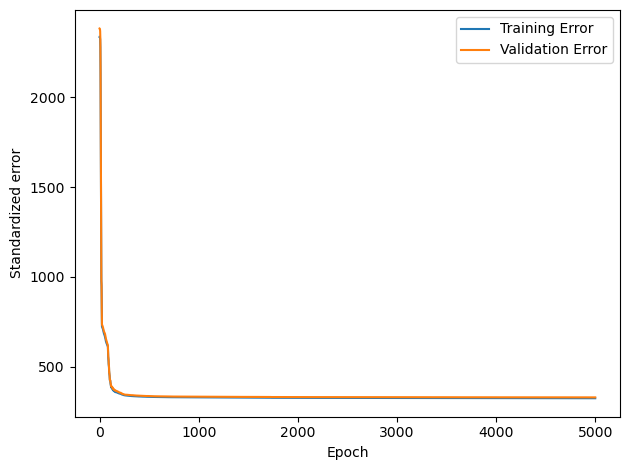

In [207]:
best_result = results_df.loc[results_df['Test Error'].idxmin()]
colors = ['b', 'r', 'g']
styles = ['-', '--']

plt.figure()
# Create an array of epoch numbers (starting from 1)
epochs = np.arange(1, best_result['Epochs'] + 1)

plt.figure()
plt.plot(best_result['Training Error Trace'], label='Training Error')
plt.plot(best_result['Validation Error Trace'], label='Validation Error')
plt.xlabel('Epoch')
plt.ylabel('Standardized error')
plt.legend()
plt.tight_layout()

## Analysis

The hyperparam configurations that led to the lowest test error involved the following:
* Optimizer: scg
* Hidden Layers: [] (linear)
* Epochs: 200
* Learning Rate: 0.05
* Batch Size: 500
* Test Error: ~321

This is very interesting. I am not surprised SCG resulted in the lowest test error, given how it performed on the previous data sets. However, I did not expect the linear model with no hidden layers to perform well. I was hoping the model with more layers/neurons performed well. The test errors seem to range quite a bit, I wonder if an increase in epochs would result in a lower error. I may try that out.

The length of the Training and Validation error traces seem wrong, I would expect there to be an error per epoch but for some reason they are each of length 5000. So the graph goes up to 5000 epochs on the x axis even though it was trained with 200 epochs. This seems like there is a bug in my code somewhere that I will have to spend some time investigating. I noticed this because I was surprised to see the error rate descend so rapidly in the early epochs and then plateu. This plateu is likely because it was actually only trained for 200 epoch and that is where the error rate stops decreasing in the graph...

## Test

This is a test for my own purposes. The errors are very high on my model and its predictions are wildly different from the target values. There probably some unnecessary features that may be causing this, but I will test that hypothesis with the extra credit. I want to increase the number of epochs on the training to see if that makes a difference. I didn't want to test this on the hyperparam tuning nested for loop because that will take too long.

In [217]:
n_epochs = 1000
nnet = nn.NeuralNetwork(Xtrain.shape[1], [20, 10, 5], 1)
nnet.train(Xtrain, Ttrain, Xval, Tval, n_epochs, batch_size=int(best_result['Batch Size']), method=best_result['Optimizer'], learning_rate=int(best_result['Learning Rate']),
           momentum=0.9, verbose=False)  # momentum only affects sgd
training_error, val_error = format_error_trace(nnet.get_error_trace())

In [218]:
 test_error = nnet.error_f(Xtest, Ttest)
test_error

708.7409011294926

Text(0.5, 1.0, 'Training Predictions vs Targets')

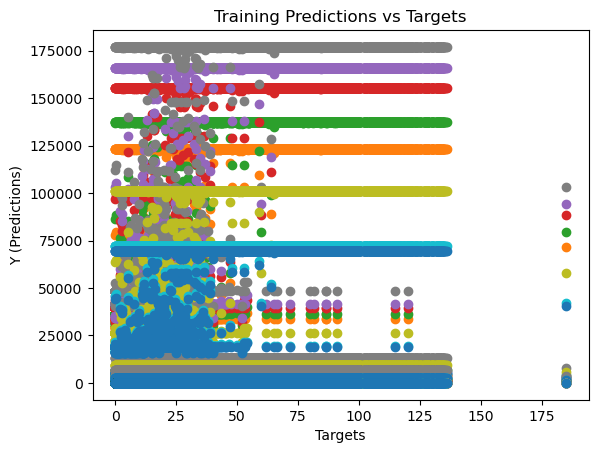

In [219]:
Ytrain = nnet.use(Xtrain)
plt.figure()
plt.plot(Ttrain, Ytrain, 'o')
plt.xlabel('Targets')
plt.ylabel('Y (Predictions)')
plt.title('Training Predictions vs Targets')

The error about doubled with this different configuration. Interesting...

## Task

Train another network using the best parameter values shown in your results.  In three separate plots, plot the predicted critical temperature versus the actual (target) critical temperatures for the training, validation, and test sets.  <font color=red>Discuss what you see. How well does your neural network predict the critical temperatures?</font>

In [211]:
# use best_result Hidden Layers
nnet = nn.NeuralNetwork(Xtrain.shape[1], [], 1)
nnet.train(Xtrain, Ttrain, Xval, Tval, best_result['Epochs'], batch_size=int(best_result['Batch Size']), method=best_result['Optimizer'], learning_rate=int(best_result['Learning Rate']),
           momentum=0.9, verbose=False)  # momentum only affects sgd
training_error, val_error = format_error_trace(nnet.get_error_trace())

In [93]:
# TODO: Fix return type of use() method
Ytrain = nnet.use(Xtrain)
Yval = nnet.use(Xval)
Ytest = nnet.use(Xtest)

In [94]:
Ytrain.shape, Ttrain.shape

((12758, 81), (12758, 1))

Text(0.5, 1.0, 'Training Predictions vs Targets')

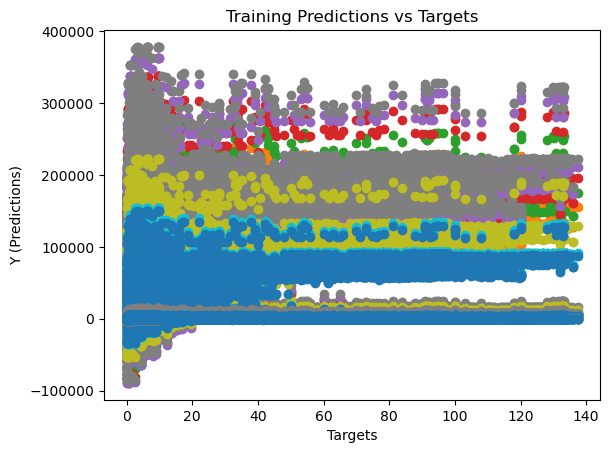

In [98]:
plt.figure()
plt.plot(Ttrain, Ytrain, 'o')
plt.xlabel('Targets')
plt.ylabel('Y (Predictions)')
plt.title('Training Predictions vs Targets')

ValueError: The truth value of an array with more than one element is ambiguous. Use a.any() or a.all()

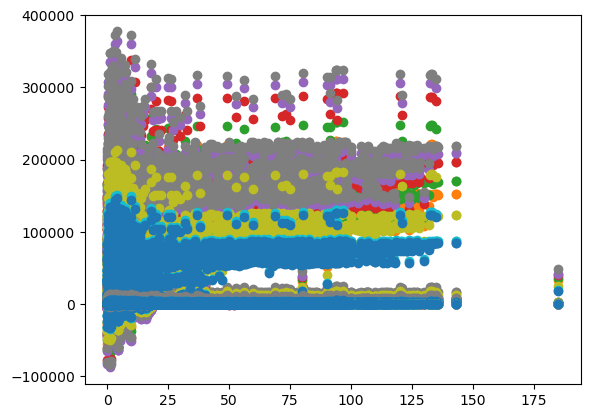

In [100]:
plt.figure()
plt.plot(Tval, Yval, 'o')
a = min(min(Tval), min(Yval))[0]
b = max(max(Tval), max(Yval))[0]
plt.axline((a, a), (b, b), linewidth=4, color='r', alpha=0.5)
plt.xlabel('T')
plt.ylabel('Y')
plt.title('Validation Predictions vs Targets')

ValueError: The truth value of an array with more than one element is ambiguous. Use a.any() or a.all()

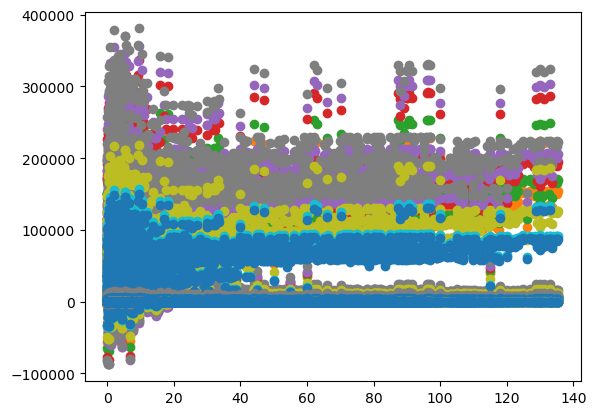

In [102]:
plt.plot(Ttest, Ytest, 'o')
a = min(min(Tval), min(Yval))[0]
b = max(max(Tval), max(Yval))[0]
plt.axline((a, a), (b, b), linewidth=4, color='r', alpha=0.5)
plt.xlabel('T')
plt.ylabel('Y')
plt.title('Test Predictions vs Targets')

## Analysis

Looking at the model's predictions vs the targets, the model does not do a good job at all at predicting the critical temperature currently. We'd like to see a lineara trajectory of the data points, but we do not. The scale of the actual predictions vs the targets is also significantly different. For exmaple, the targets are all between 0-140 while the model's predictions range from -1000000 to 4000000. I noticed there are some NaNs in the error traces and that might be contributing to this. Im not sure right now where those NaNs are coming from but that warrants further investigation. 

All in all, I think there might be too many features, not enough neurons, and it may need to train for more epochs to be able to accuratley predict the critical temp. I have not tested these changes to the model because of how long its taking to train. I didn't want to waste too much time messing with the hyperparams for the assignment.

# Grading

Your notebook will be run and graded automatically. Test this grading process by first downloading [A3grader.zip](http://www.cs.colostate.edu/~anderson/cs545/notebooks/A3grader.zip) and extract `A3grader.py` from it. Run the code in the following cell to demonstrate an example grading session. As always, a different, but similar, grading script will be used to grade your checked-in notebook. It will include additional tests. You should design and perform additional tests on all of your functions to be sure they run correctly before checking in your notebook.  

For the grading script to run correctly, you must first name this notebook as 'A3solution.ipynb' (lower case s) and then save this notebook. Check in your notebook in Canvas.


In [ ]:
%run -i A3grader.py

# Extra Credit

Using a network that gives you pretty good test RMSE results, try to figure out which input features are most significant in predicting the critical temperature.  Remember, that our neural networks are trained with standardized inputs, so you can compare the magnitudes of weights in the first layer to help you determine which inputs are most significant. 

To visualize the weights, try displaying the weights in the first layer as an image, with `plt.imshow` with `plt.colorbar()`. Discuss which weights have the largest magnitudes and discuss any patterns you see in the weights in each hidden unit of the first layer.

Retrain your neural network after removing half of the inputs for which the first layer of your network has the lowest mean absolute weights.  Discuss how this affects the three RMSE values.